In [1]:
library(tidyverse)
install.packages('ISLR')
library('ISLR')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.3.6      ✔ purrr   0.3.5 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.4.1 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“unable to access index for repository http://cran.rstudio.com/src/contrib:
  cannot open URL 'http://cran.rstudio.com/src/contrib/PACKAGES'”
Warning message:
“package ‘ISLR’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”


# 9.6
At the end of Section 9.6.1, it is claimed that in the case of data that
is just barely linearly separable, a support vector classifier with a
small value of cost that misclassifies a couple of training observations
may perform better on test data than one with a huge value of cost
that does not misclassify any training observations. You will now
investigate this claim

In [2]:
if(!require('latex2exp')) {
  install.packages('latex2exp')
  library('latex2exp')
}
if(!require('e1071')) {
  install.packages('e1071')
  library('e1071')
}
if(!require('scales')) {
  install.packages('scales')
  library('scales')
}
if(!require('gridExtra')) {
install.packages('gridExtra')
library('gridExtra')
}

Loading required package: latex2exp

Loading required package: e1071

Loading required package: scales


Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor


Loading required package: gridExtra


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




# 9.6A
Generate two-class data with p = 2 in such a way that the classes
are just barely linearly separable.

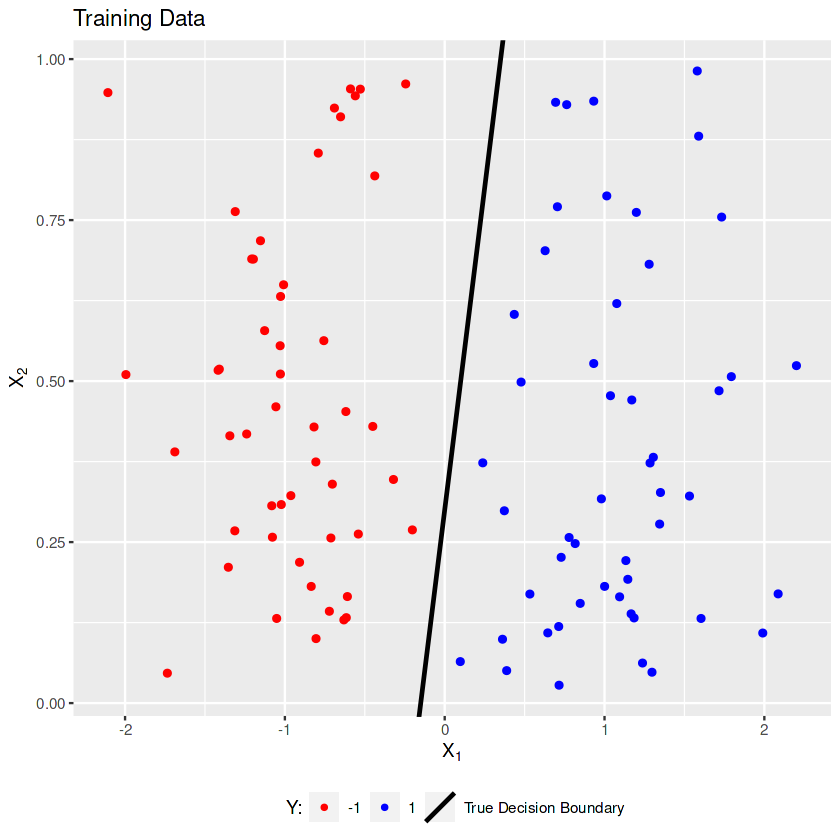

In [3]:
set.seed(1)
X1 <- c(rnorm(50, mean = -1, sd = 0.5), rnorm(50, mean = 1, sd = 0.5))
X2 <- runif(100)
Y <- ifelse(X2 > 2*X1 + 0.3, -1, 1)
train <- data.frame(X1, X2, Y = factor(Y))

ggplot(train) + 
  geom_point(aes(x = X1, y = X2, col = factor(Y))) + 
  geom_abline(aes(intercept = 0.3, slope = 2, col = "True Decision Boundary"), size = 1) + 
  scale_color_manual(values = c('red', 'blue', 'black'),
                     guide = guide_legend(override.aes = list(pch = c(16, 16, NA), linetype = c(0, 0, 1)))) + 
  theme(legend.position = "bottom") + 
  labs(title = "Training Data", 
       col = "Y:", 
       x = TeX(r'($X_1$)'), 
       y = TeX(r'($X_2$)'))

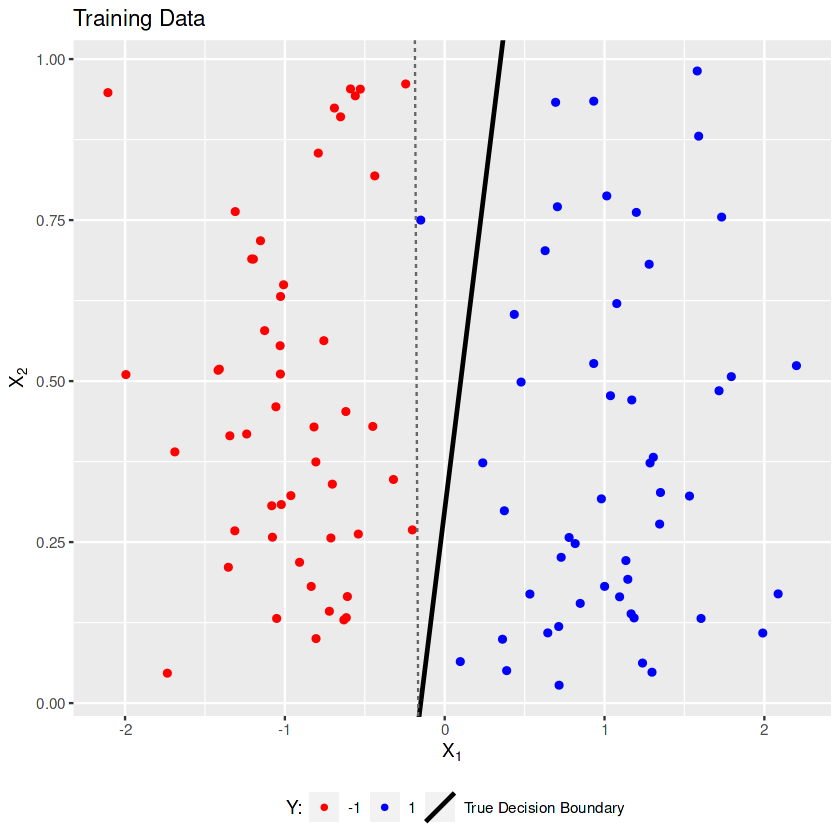

In [4]:
outlier <- data.frame(X1 = -0.15, X2 = 0.75, Y = factor(1, levels = c("-1", "1")))
train[100, ] <- outlier


ggplot(train) + 
  geom_point(aes(x = X1, y = X2, col = factor(Y))) + 
  geom_abline(aes(intercept = 0.3, slope = 2, col = "True Decision Boundary"), size = 1) + 
  scale_color_manual(values = c('red', 'blue', 'black'),
                     guide = guide_legend(override.aes = list(pch = c(16, 16, NA), linetype = c(0, 0, 1)))) + 
  geom_abline(intercept = -8.3, slope = -50, linetype = 'dashed', col = 'grey40') + 
  theme(legend.position = "bottom") + 
  labs(title = "Training Data", 
       col = "Y:", 
       x = TeX(r'($X_1$)'), 
       y = TeX(r'($X_2$)'))

# 

# 9.6B
Compute the cross-validation error rates for support vector
classifiers with a range of cost values. How many training errors are misclassified for each value of cost considered, and how
does this relate to the cross-validation errors obtained?

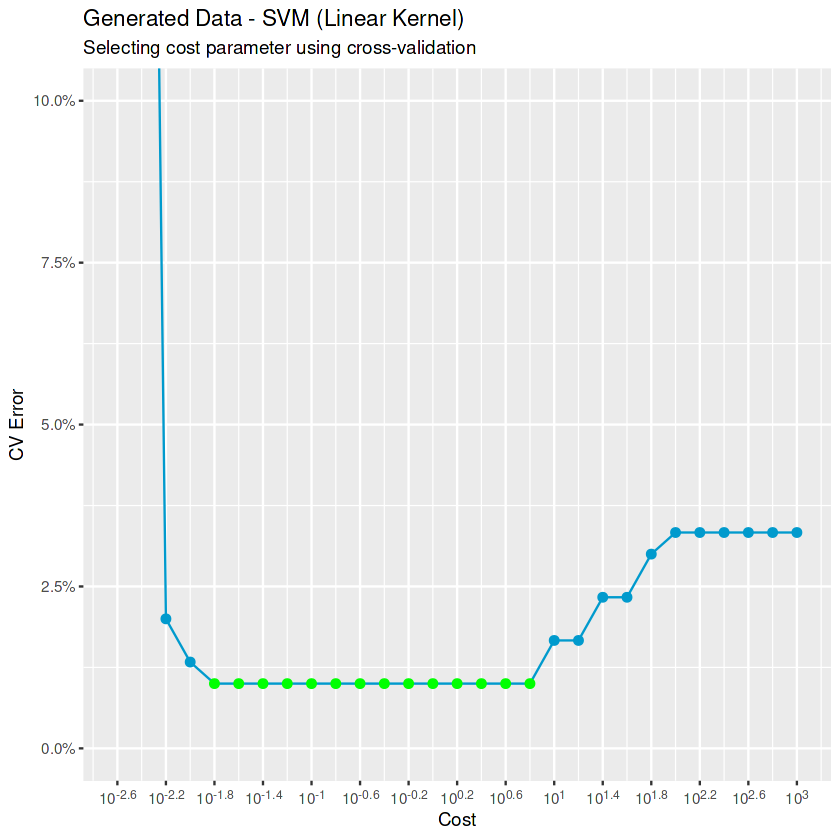

In [5]:
# 3 repeats of 10-fold cross-validation:
power_range <- seq(-2.6, 3, 0.2)
cost_range <- 10^power_range
number <- 10
repeats <- 3

cv_matrix <- matrix(nrow = length(cost_range), ncol = repeats)

set.seed(1)

for (i in 1:repeats) {
  svm_linear_tune <- tune(svm, Y ~ X1 + X2, data = train, kernel = "linear", scale = FALSE, ranges = list(cost = cost_range), tunecontrol = tune.control(sampling = "cross", cross = number))
  cv_matrix[ ,i] <- svm_linear_tune$performances$error
}


data.frame(cost = cost_range, CV_error = rowMeans(cv_matrix)) %>%
  mutate(min_CV_error = as.numeric(CV_error == min(CV_error))) %>%
  ggplot(aes(x = cost, y = CV_error)) + 
  geom_line(col = "deepskyblue3") + 
  geom_point(size = 2, aes(col = factor(min_CV_error))) +
  scale_x_continuous(trans = 'log10', breaks = cost_range[seq(1, length(cost_range), 2)], labels = paste0("10^", round(power_range[seq(1, length(power_range), 2)], 1))) + 
  scale_y_continuous(labels = percent_format()) +
  scale_color_manual(values = c("deepskyblue3", "green")) + 
  coord_cartesian(ylim = c(0, 0.1)) +
  theme(legend.position = "none", 
        axis.text.x = ggtext::element_markdown()) + 
  labs(title = "Generated Data - SVM (Linear Kernel)", 
       subtitle = "Selecting cost parameter using cross-validation",
       x = "Cost", 
       y = "CV Error")

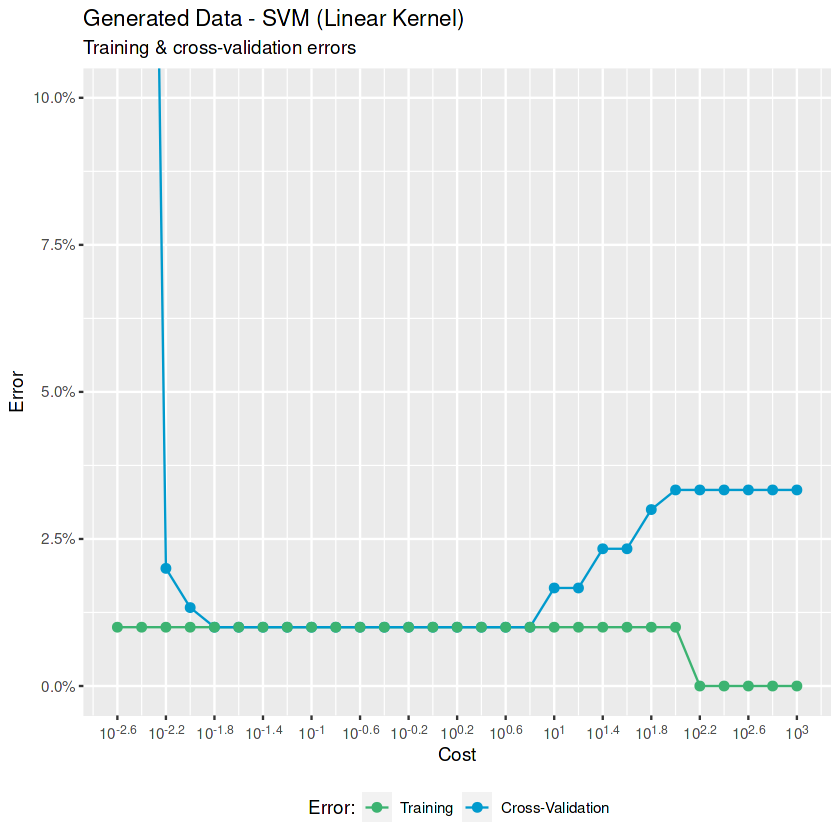

In [6]:
train_error <- c()

for (i in 1:length(cost_range)) {
  svm_linear <- svm(Y ~ X1 + X2, data = train, kernel = "linear", scale = FALSE, cost = cost_range[i])
  train_error[i] <- sum(predict(svm_linear, train) != train$Y) / nrow(train)
}


data.frame(cost = cost_range, CV_error = rowMeans(cv_matrix), train_error) %>%
  pivot_longer(cols = c("CV_error", "train_error")) %>%
  mutate(name = factor(name, ordered = T, levels = c("train_error", "CV_error"))) %>%
  ggplot(aes(x = cost, y = value, group = name, col = name)) + 
  geom_line() + 
  geom_point(size = 2) + 
  scale_x_continuous(trans = 'log10', breaks = cost_range[seq(1, length(cost_range), 2)], labels = paste0("10^", round(power_range[seq(1, length(power_range), 2)], 1))) + 
  scale_y_continuous(labels = percent_format()) +
  scale_color_manual(values = c("mediumseagreen", "deepskyblue3"), labels = c("Training", "Cross-Validation")) + 
  coord_cartesian(ylim = c(0, 0.1)) +
  theme(legend.position = "bottom", 
        axis.text.x = ggtext::element_markdown()) + 
  labs(title = "Generated Data - SVM (Linear Kernel)", 
       subtitle = "Training & cross-validation errors",
       x = "Cost", 
       y = "Error", 
       col = "Error:")

The higher levels of Cost decrease the training error with the error rate eventually reaching zero.  Since this data is linearly separable the cost of a violation will be high that all training observations will be correctly classified.  Note: the lowest training errors do not correlate with the lowerst cross validation error.

# 9.6C
Generate an appropriate test data set, and compute the test errors corresponding to each of the values of cost considered. Which value of cost leads to the fewest test errors, and how does this compare to the values of cost that yield the fewest training errors and the fewest cross-validation errors?

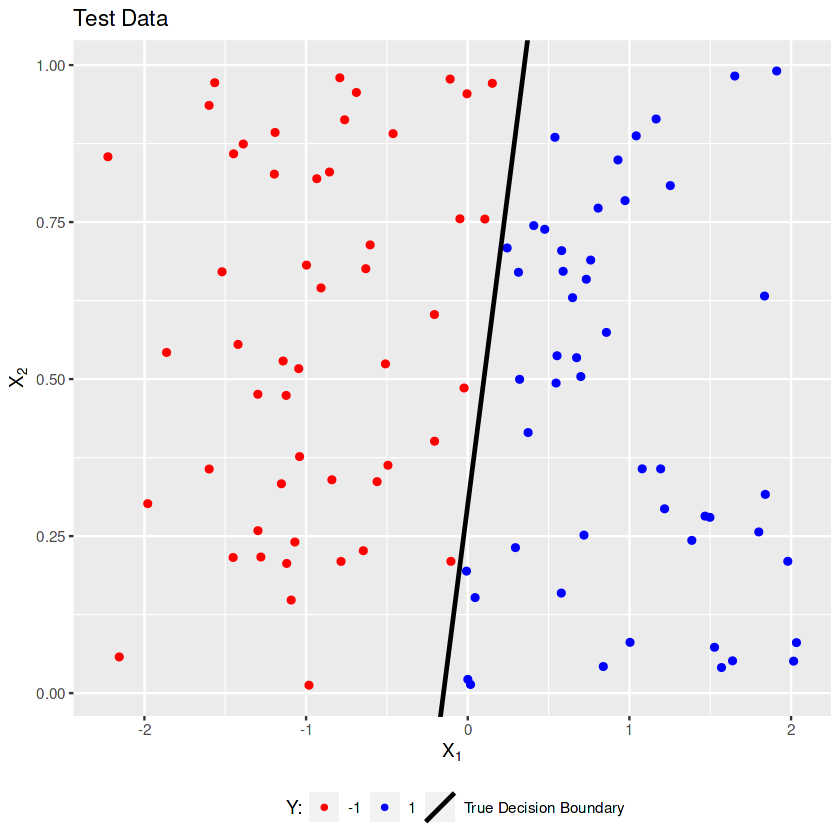

In [7]:
set.seed(2)
X1 <- c(rnorm(50, mean = -1, sd = 0.5), rnorm(50, mean = 1, sd = 0.5))
X2 <- runif(100)
Y <- ifelse(X2 > 2*X1 + 0.3, -1, 1)
test <- data.frame(X1, X2, Y = factor(Y))

ggplot(test) + 
  geom_point(aes(x = X1, y = X2, col = factor(Y))) + 
  geom_abline(aes(intercept = 0.3, slope = 2, col = "True Decision Boundary"), size = 1) + 
  scale_color_manual(values = c('red', 'blue', 'black'),
                     guide = guide_legend(override.aes = list(pch = c(16, 16, NA), linetype = c(0, 0, 1)))) + 
  theme(legend.position = "bottom") + 
  labs(title = "Test Data", 
       col = "Y:", 
       x = TeX(r'($X_1$)'), 
       y = TeX(r'($X_2$)'))

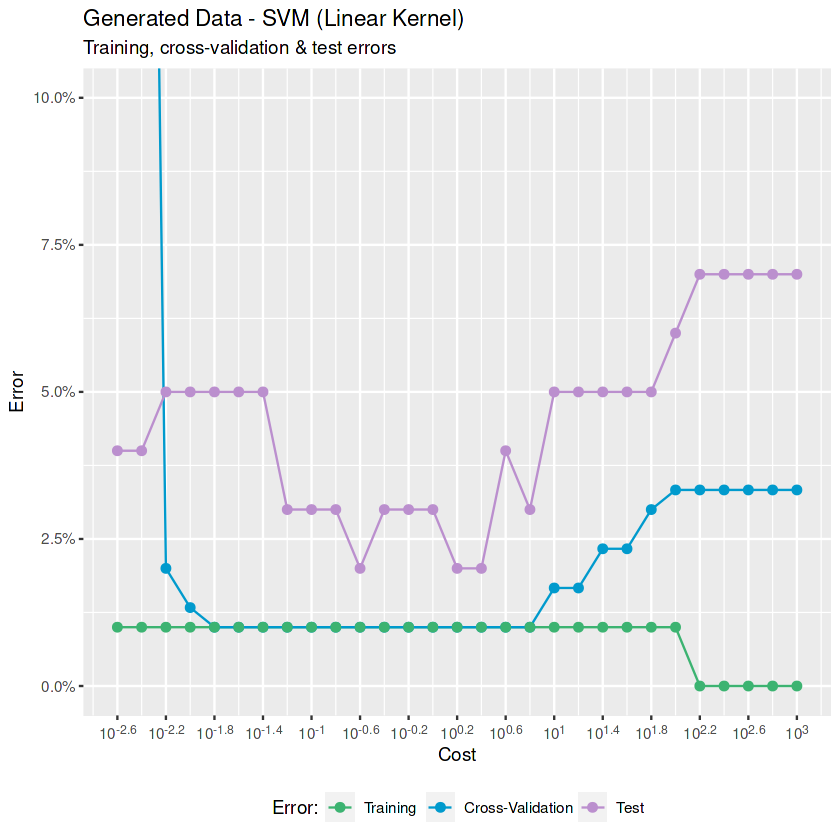

In [8]:
test_error <- c()

for (i in 1:length(cost_range)) {
  svm_linear <- svm(Y ~ X1 + X2, data = train, kernel = "linear", scale = FALSE, cost = cost_range[i])
  test_error[i] <- sum(predict(svm_linear, test) != test$Y) / nrow(test)
}

train_test_cv_df <- data.frame(cost = cost_range, power = power_range, CV_error = rowMeans(cv_matrix), train_error, test_error)


train_test_cv_df %>%
  pivot_longer(cols = c("CV_error", "train_error", "test_error")) %>%
  mutate(name = factor(name, ordered = T, levels = c("train_error", "CV_error", "test_error"))) %>%
  ggplot(aes(x = cost, y = value, group = name, col = name)) + 
  geom_line() + 
  geom_point(size = 2) + 
  scale_x_continuous(trans = 'log10', breaks = cost_range[seq(1, length(cost_range), 2)], labels = paste0("10^", round(power_range[seq(1, length(power_range), 2)], 1))) + 
  scale_y_continuous(labels = percent_format()) +
  coord_cartesian(ylim = c(0, 0.1)) +
  scale_color_manual(values = c("mediumseagreen", "deepskyblue3", "#BB8FCE"), labels = c("Training", "Cross-Validation", "Test")) + 
  theme(legend.position = "bottom", 
        axis.text.x = ggtext::element_markdown()) + 
  labs(title = "Generated Data - SVM (Linear Kernel)", 
       subtitle = "Training, cross-validation & test errors",
       x = "Cost", 
       y = "Error", 
       col = "Error:")

The model with the lowest training error performed poorly on the Test Data.  The best selection would be the model that has the lowest test and training error that correlates with best cross validation.  In this case it would be the model where cost = 10^-0.6


# 9.6D
Comment on your results.

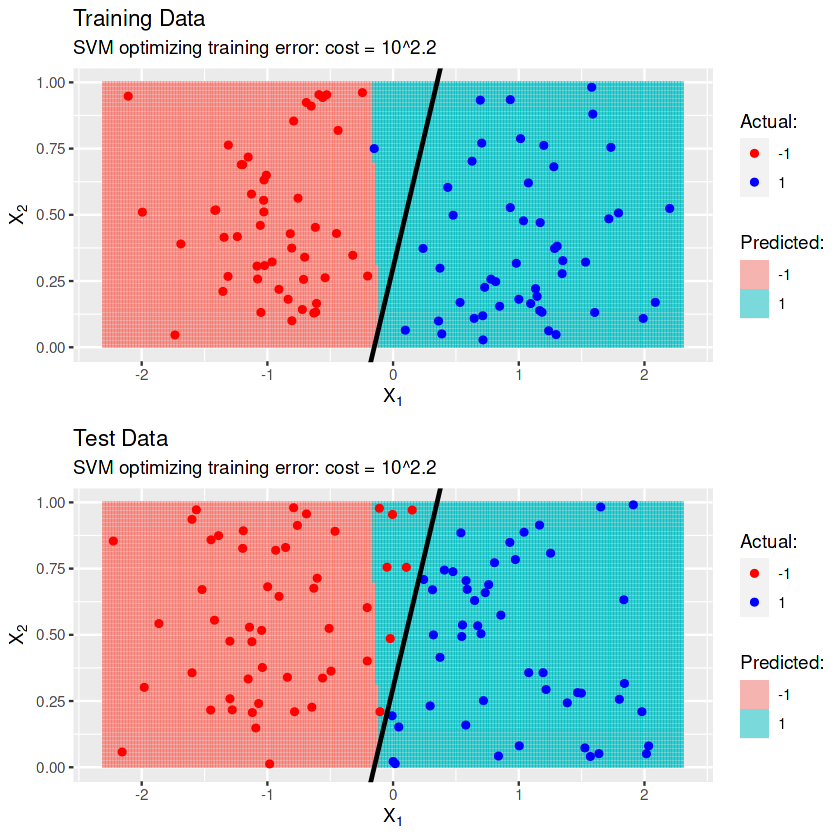

In [9]:
svm_linear <- svm(Y ~ X1 + X2, data = train, kernel = "linear", scale = FALSE, cost = 10^2.2)

grid <- expand.grid(X1 = seq(-2.3, 2.3, length.out = 200), X2 = seq(0, 1, length.out = 200))
grid$class_pred <- predict(svm_linear, grid)

g1 <- ggplot(grid, aes(x = X1, y = X2)) + 
  geom_tile(aes(fill = class_pred), alpha = 0.5) +
  geom_point(data = train, aes(col = Y)) +
  geom_abline(intercept = 0.3, slope = 2, size = 1) + 
  scale_color_manual(values = c("red", "blue")) + 
  labs(title = "Training Data", 
       subtitle = "SVM optimizing training error: cost = 10^2.2", 
       fill = "Predicted:", 
       shape = "Support Vector:", 
       col = "Actual:", 
       x = TeX(r'($X_1$)'), 
       y = TeX(r'($X_2$)'))

g2 <- ggplot(grid, aes(x = X1, y = X2)) + 
  geom_tile(aes(fill = class_pred), alpha = 0.5) +
  geom_point(data = test, aes(col = Y)) +
  geom_abline(intercept = 0.3, slope = 2, size = 1) + 
  scale_color_manual(values = c("red", "blue")) + 
  labs(title = "Test Data", 
       subtitle = "SVM optimizing training error: cost = 10^2.2", 
       fill = "Predicted:", 
       shape = "Support Vector:", 
       col = "Actual:", 
       x = TeX(r'($X_1$)'), 
       y = TeX(r'($X_2$)'))


grid.arrange(g1, g2, nrow = 2)

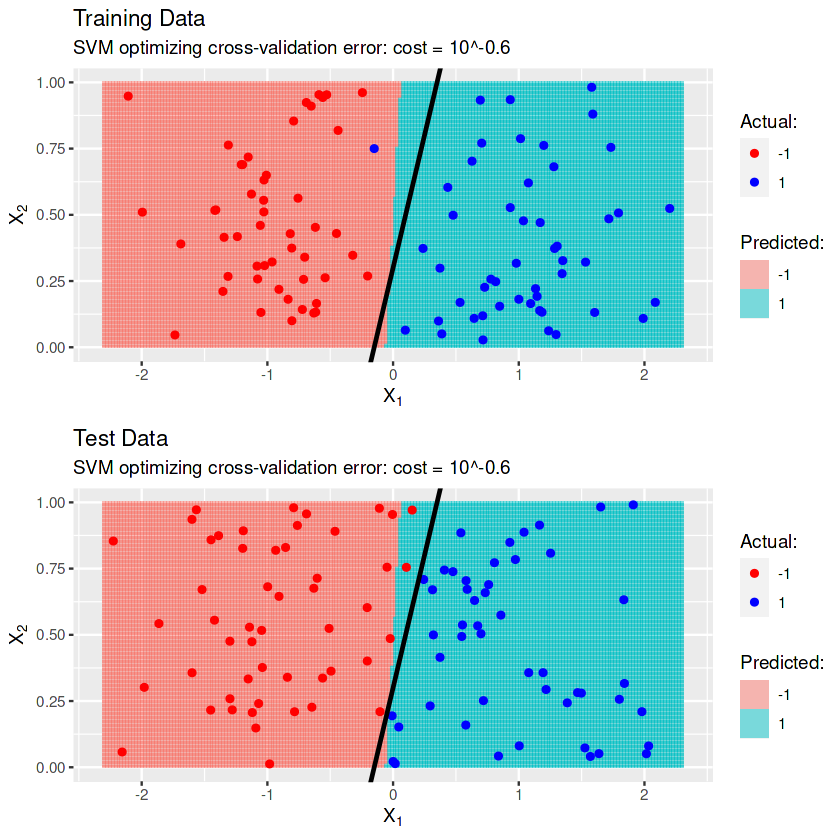

In [10]:
svm_linear <- svm(Y ~ X1 + X2, data = train, kernel = "linear", scale = FALSE, cost = 10^-0.6)

grid <- expand.grid(X1 = seq(-2.3, 2.3, length.out = 200), X2 = seq(0, 1, length.out = 200))
grid$class_pred <- predict(svm_linear, grid)

g1 <- ggplot(grid, aes(x = X1, y = X2)) + 
  geom_tile(aes(fill = class_pred), alpha = 0.5) +
  geom_point(data = train, aes(col = Y)) +
  geom_abline(intercept = 0.3, slope = 2, size = 1) + 
  scale_color_manual(values = c("red", "blue")) + 
  labs(title = "Training Data", 
       subtitle = "SVM optimizing cross-validation error: cost = 10^-0.6", 
       fill = "Predicted:", 
       shape = "Support Vector:", 
       col = "Actual:", 
       x = TeX(r'($X_1$)'), 
       y = TeX(r'($X_2$)'))

g2 <- ggplot(grid, aes(x = X1, y = X2)) + 
  geom_tile(aes(fill = class_pred), alpha = 0.5) +
  geom_point(data = test, aes(col = Y)) +
  geom_abline(intercept = 0.3, slope = 2, size = 1) + 
  scale_color_manual(values = c("red", "blue")) + 
  labs(title = "Test Data", 
       subtitle = "SVM optimizing cross-validation error: cost = 10^-0.6", 
       fill = "Predicted:", 
       shape = "Support Vector:", 
       col = "Actual:", 
       x = TeX(r'($X_1$)'), 
       y = TeX(r'($X_2$)'))

grid.arrange(g1, g2, nrow = 2)

For this dataset we may actually recieve better overall results by allowing for a few misclassifications of training observations rather then have a large value of cost that does not misclassify anything.  This will result in fewer test errors.  